## Color: Cardinality vs Performance

- **Models**: BERT, CLIP, FLAVA  (+CoDa)
- **Metrics**: Rel-Accuracy & Confidence

In [2]:
import pandas as pd


In [30]:
df = pd.read_csv('../temp/flava_col.csv')

df.head()

,true,pred,prob
0,"3,7,8,10",3,"0.05585075542330742,0.024501027539372444,0.025..."
1,"0,1,10",10,"0.0749174952507019,0.021220631897449493,0.0672..."
2,"0,3,8,10",8,"0.05677624046802521,0.030275460332632065,0.048..."
3,"3,4",4,"0.03291339799761772,0.009773140773177147,0.031..."
4,"0,2,3,8,10",8,"0.12242279946804047,0.04770265519618988,0.0767..."


In [31]:
# To String
df['pred'] = df['pred'].apply(lambda p: str(p))


df.dtypes

true    object
pred    object
prob    object
dtype: object

<br>

Rel-Accuracy

In [32]:
df['correct'] = df.apply(lambda x: x['pred'] in x['true'].split(','), axis=1)

'R-Acc: {:.2f}'.format(df['correct'].sum() / len(df) * 100)

'R-Acc: 76.31'

<br>

Confidence

In [33]:
from torch import tensor as T


def _confidence(x):
    true = x['true'].split(',')
    true = [int(_) for _ in true]

    prob = x['prob'].split(',')
    prob = T([float(_) for _ in prob])

    return prob[true].sum().item()


df['conf'] = df.apply(lambda x: _confidence(x), axis=1)

<br>

#### Aggregate Accuracy & Confidence -- Group by Cardinality

In [34]:
df['cardinality'] = df['true'].apply(lambda x: len(x.split(',')))

df.head()

,true,pred,prob,correct,conf,cardinality
0,"3,7,8,10",3,"0.05585075542330742,0.024501027539372444,0.025...",True,0.766668,4
1,"0,1,10",10,"0.0749174952507019,0.021220631897449493,0.0672...",True,0.356880,3
2,"0,3,8,10",8,"0.05677624046802521,0.030275460332632065,0.048...",True,0.653235,4
3,"3,4",4,"0.03291339799761772,0.009773140773177147,0.031...",True,0.584805,2
4,"0,2,3,8,10",8,"0.12242279946804047,0.04770265519618988,0.0767...",True,0.731621,5


In [35]:
df.groupby('cardinality')['conf'].mean()

cardinality
1    0.334004
2    0.484917
3    0.603452
4    0.672689
5    0.718968
6    0.805971
7    0.776097
Name: conf, dtype: float64

In [36]:
df.groupby('cardinality')['correct'].mean()


cardinality
1    0.636098
2    0.779317
3    0.859143
4    0.870430
5    0.888889
6    0.959459
7    0.800000
Name: correct, dtype: float64

<br>

### CoDa

Report Performance (cardinality)

In [9]:
from collections import Counter
from utils import read_json
from misc.prior_ds import load_coda

In [ ]:
viphy = read_json('../results/colors.json')
coda_typical, coda_prob = load_coda()

In [4]:
# Common Objects
viphy_objects = set(viphy.keys())

coda_prob = {o: v for o, v in coda_prob.items() if o in viphy_objects}
coda_typical = {o: v for o, v in coda_typical.items() if o in viphy_objects}

In [12]:
lens = [len(c) for o, c in coda_typical.items()]

cardinality_freq = dict(Counter(lens))
sorted(cardinality_freq.items())

[(1, 176), (2, 89), (3, 61), (4, 87), (5, 15), (6, 4)]

In [18]:
coda_data = [{'obj': o, 'pred': c, 'true': list(viphy[o]), 'cardinality': len(viphy[o])}
             for o, c in coda_typical.items()]

df_coda = pd.DataFrame.from_dict(coda_data)

df_coda.head()

,obj,pred,true,cardinality
0,ruler,"{'brown': 0.5052238702774048, 'yellow': 0.4947...","[yellow, white, gray]",3
1,toothbrush,"{'blue': 0.3552764654159546, 'green': 0.183714...","[blue, white]",2
2,house,"{'brown': 0.43336084485054016, 'white': 0.5666...","[brown, white]",2
3,cake,"{'brown': 0.3400912582874298, 'pink': 0.277795...","[brown, white]",2
4,parachute,"{'blue': 0.1406806856393814, 'green': 0.159843...","[red, orange, yellow, blue, white, black]",6


In [30]:
df_coda['conf'] = df_coda.apply(lambda x: sum(p for o, p in x['pred'].items() if o in x['true']), axis=1)

df_coda['correct'] = df_coda.apply(lambda x: 1 if set(x['pred']) & set(x['true']) else 0, axis=1)

df_coda['correct'].mean(), df_coda['conf'].mean()

(0.9745370370370371, 0.7865998609232958)

In [31]:
df_coda.head(10)

,obj,pred,true,cardinality,conf,correct
0,ruler,"{'brown': 0.5052238702774048, 'yellow': 0.4947...","[yellow, white, gray]",3,0.494776,1
1,toothbrush,"{'blue': 0.3552764654159546, 'green': 0.183714...","[blue, white]",2,0.641483,1
2,house,"{'brown': 0.43336084485054016, 'white': 0.5666...","[brown, white]",2,1.000000,1
3,cake,"{'brown': 0.3400912582874298, 'pink': 0.277795...","[brown, white]",2,0.722204,1
4,parachute,"{'blue': 0.1406806856393814, 'green': 0.159843...","[red, orange, yellow, blue, white, black]",6,0.840156,1
5,glove,"{'black': 0.6481090784072876, 'white': 0.35189...","[brown, white, black]",3,1.000000,1
6,fish,"{'gray': 0.4017074704170227, 'green': 0.330038...","[orange, blue, white, gray, black]",5,0.401707,1
7,dragonfly,"{'blue': 0.21870826184749603, 'brown': 0.15456...","[orange, brown, black]",3,0.154566,1
8,umbrella,{'black': 1.0},"[red, blue, white, black]",4,1.000000,1
9,billboard,"{'blue': 0.41985902190208435, 'red': 0.3315967...","[red, blue, white, black]",4,1.000000,1


In [32]:
df_coda.groupby('cardinality')['conf'].mean()

cardinality
1    0.756900
2    0.770236
3    0.837567
4    0.835737
5    0.830399
6    0.928076
Name: conf, dtype: float64

In [33]:
df_coda.groupby('cardinality')['correct'].mean()

cardinality
1    0.964646
2    0.967391
3    1.000000
4    0.986111
5    1.000000
6    1.000000
Name: correct, dtype: float64


<br><br>

## Plot Curves -- Metric(s) vs #Labels

In [1]:
import matplotlib.pyplot as plt

In [2]:
bert_conf = [0.254481, 0.429102, 0.565140, 0.646456, 0.693855, 0.769546, 0.772170]
bert_acc = [0.485981, 0.670822, 0.814523, 0.840860, 0.860697, 0.891892, 0.900233]

flava_conf = [0.334004, 0.484917, 0.603452, 0.672689, 0.718968, 0.805971, 0.776097]
flava_acc = [0.636098, 0.779317, 0.859143, 0.870430, 0.888889, 0.959459, 0.913001]

clip_conf = [0.479512, 0.586562, 0.679729, 0.740048, 0.769165, 0.834552, 0.797665]
clip_acc = [0.704731, 0.812096, 0.874891, 0.891935, 0.875622, 0.918919, 0.890000]

coda_conf = [0.756900, 0.770236, 0.837567, 0.835737, 0.830399, 0.928076]
coda_acc = [0.964646, 0.967391, 1.000000, 0.986111, 1.000000, 1.000000]

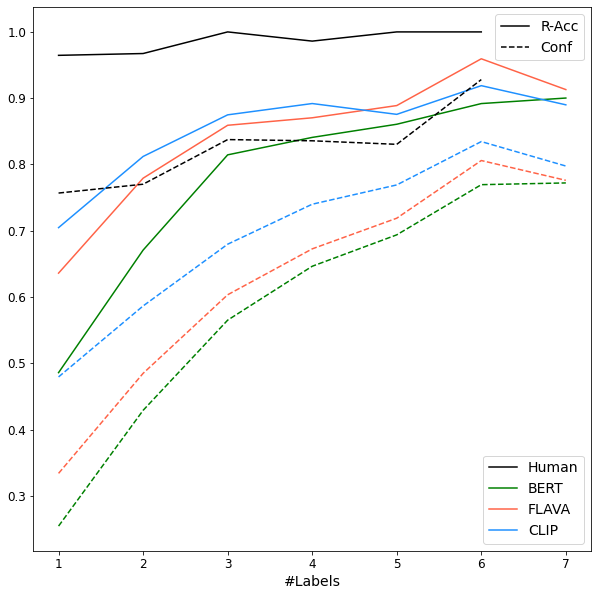

In [13]:
# Font
plt.rcParams.update({'font.size': 14})

# Style
acc_style = 'solid'
conf_style = 'dashed'

plt.figure(figsize=(10, 10))

# X-axis
x = [1, 2, 3, 4, 5, 6, 7]

# Plot
col_h,  = plt.plot(x[:-1], coda_acc, label="Human", linestyle=acc_style, color='black')
col_b, = plt.plot(x, bert_acc, label="BERT", linestyle=acc_style, color='green')
col_f, = plt.plot(x, flava_acc, label="FLAVA", linestyle=acc_style, color='tomato')
col_c, = plt.plot(x, clip_acc, label="CLIP", linestyle=acc_style, color='dodgerblue')

plt.plot(x[:-1], coda_conf, linestyle=conf_style, color='black')
plt.plot(x, bert_conf, linestyle=conf_style, color='green')
plt.plot(x, flava_conf, linestyle=conf_style, color='tomato')
plt.plot(x, clip_conf, linestyle=conf_style, color='dodgerblue')

color_legend = plt.legend(handles=[col_h, col_b, col_f, col_c], loc='lower right')
plt.gca().add_artist(color_legend)

# Dummy (legend)
line_acc, = plt.plot([1], [1], label="R-Acc", linestyle=acc_style, color='black')
line_conf, = plt.plot([1], [1], label="Conf", linestyle=conf_style, color='black')

style_legend = plt.legend(handles=[line_acc, line_conf], loc='upper right')

plt.xlabel('#Labels')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()
# plt.savefig('../visualize/col_card.pdf', bbox_inches='tight')
